In [5]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Space for Commands:
# %pip install

     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     --------------------------------- ---- 143.4/162.8 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 162.8/162.8 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ------ --------------------------------- 1.2/7.7 MB 39.6 MB/s eta 0:00:01
   ---------------- ----------------------- 3.2/7.7 MB 41.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.7 MB 41.7 MB/s eta 0:00:01
   ------------------------------------- -- 7.2/7.7 MB 41.8 MB/s eta 0:00:01
   ---------------------------------------- 7.7/7.7 MB 37.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/182.8 kB ? eta -:--:--
   ---------------------------------------- 182.8/182.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------------- ---------- 1.6/2.2 MB 51.2 MB/s eta 0:00:01
   --------------------

## Import Libraries

In [18]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [19]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

In [20]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)


## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [22]:
# Import required libraries
import matplotlib.pyplot as plt
import os

def plot_accuracy(history, title, params_string="undefined"):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, "accuracy_" + params_string)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, "loss_" + params_string)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))

def save_plot(plt, params_string):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    params_string (String): A String meant to contain the parameters which will be used as the filename. Cannot contain spaces
    """
    filename = "Graphs/" + "Plot_using_" + params_string
    if os.path.exists(filename):
        filename += "I"
    plt.savefig(filename)


In [26]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam'):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    r_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [28]:
# Build ResNet model
resnet_model = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam')
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 64)   1792        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 32, 32, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_24[0]

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

In [30]:
resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, Y_test))


Epoch 1/10
782/782 [==============================] - 14s 16ms/step - loss: 1.1533 - accuracy: 0.5900 - val_loss: 1.0197 - val_accuracy: 0.6451
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 0.7437 - accuracy: 0.7411 - val_loss: 0.7399 - val_accuracy: 0.7446
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 0.5974 - accuracy: 0.7938 - val_loss: 1.0634 - val_accuracy: 0.6758
Epoch 4/10
782/782 [==============================] - 12s 16ms/step - loss: 0.5024 - accuracy: 0.8273 - val_loss: 0.7816 - val_accuracy: 0.7423
Epoch 5/10
782/782 [==============================] - 12s 16ms/step - loss: 0.4222 - accuracy: 0.8547 - val_loss: 0.6900 - val_accuracy: 0.7730
Epoch 6/10
782/782 [==============================] - 12s 16ms/step - loss: 0.3584 - accuracy: 0.8771 - val_loss: 0.6065 - val_accuracy: 0.8017
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.2984 - accuracy: 0.8975 - val_loss: 0.6328 - val_accuracy:

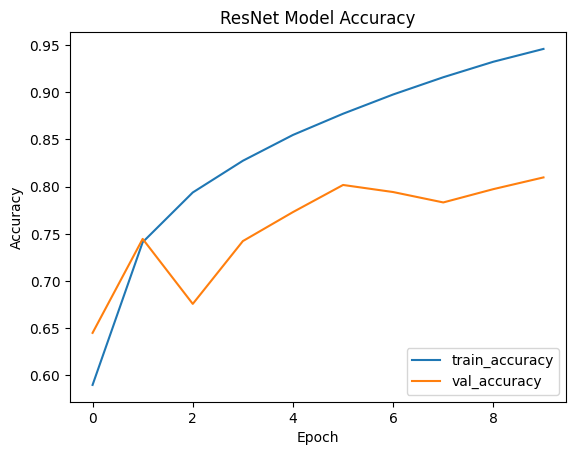

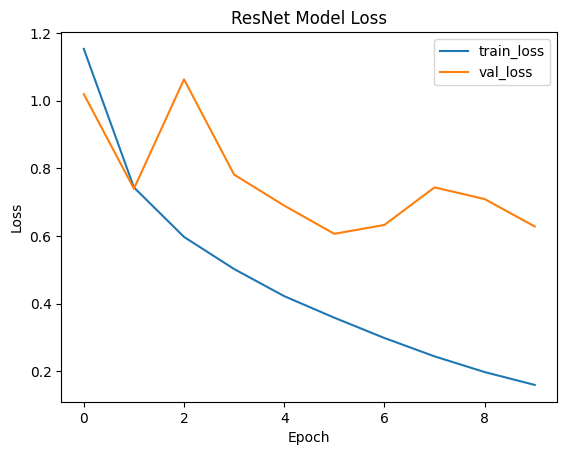

ResNet Model:
Test Accuracy: 80.97%


In [31]:
# Plot accuracy and loss
plot_accuracy(resnet_history, 'ResNet Model Accuracy')
plot_loss(resnet_history, 'ResNet Model Loss')

# Evaluate the model
print('ResNet Model:')
evaluate_model(resnet_model, X_test, Y_test)